---
# **Progetto B2**: Segmentation & Domain Shift Analysis
## **Corso**: Visione Computerizzata e Sistemi Cognitivi
**Obiettivo**: Costruire una U-Net per la segmentazione semantica e analizzare quanto il modello sia robusto quando i dati di test differiscono da quelli di training (Domain Shift).

Alessandro Scatto m: 0322500036
---

La base di partenza è una configurazione standard prendendo spunto dallo script nel GIT del corso lab05.ipynb (https://github.com/San-Raffaele-AI-Lab/VC_lab_05_aa25-26) che con Python & PyTorch addestra una rete convoluzionale di classificazione

Rispetto la laboratorio ho eseguito alcuni testdi valori della batch size per testare le performance del Runtime T4 GPU di Colab
Come learning rate parto dal default di Adam (la scelta di questo ottimizzatore sarà discussa nella relazione) farò dei successivi test empirici in fase di Model Selection
Parto  con un numero di epoche = 10 per poi verificare monitorando  le curve della Training Loss e della Validation Loss

Sto usando il device: cuda
Scaricamento dati in corso...
dati pronti caricati e normalizzati
3 immagini e maschere di esempio...


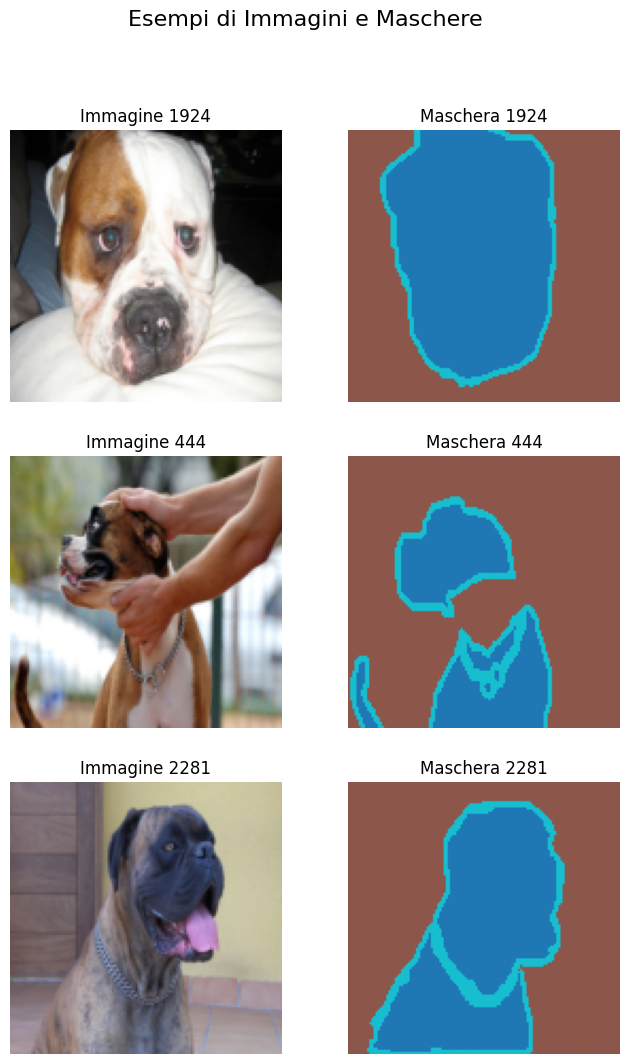

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
# from torchview import draw_graph
import random

# CONFIGURAZIONI
# Imposto la dimensione a 128x128  ed un batch_size adeguato per le performance disponibili utilizzando un Runtime T4 a GPU di COLAB
IMG_SIZE = 128
BATCH_SIZE = 128 # proviamo ad alzare se il runtime tiene
LEARNING_RATE = 0.001 # adam default poi si può provare a cambiare
EPOCHS = 12 # da tarare

# Configurazione Device (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sto usando il device: {device}")

# ---------------------------------------------------------
# CARICAMENTO DEL DATASET Oxford-IIIT Pet
# ---------------------------------------------------------

# istanzio una pipeline per trasformare le immagini, faccio un resize alla dimensione predefinita e transformo in tensore PyTorch (normalizzando)
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# in modo simile, ma lavorando su maschere di segmentazione, creo una pipeline per le maschere
# stavolta devo modificare l'interpolazione e non usare la normalizzazione
mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

# istanzio una classe che fa da adattatore, estendendo OxfordIIITPet
class OxfordPetDataset(datasets.OxfordIIITPet):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        # Le maschere originali hanno valori: 1 (animale), 2 (sfondo), 3 (bordo).
        # PyTorch prevede classi da 0, quindi sottraggo 1 agli elementi della maschera
        return img_transform(img), mask_transform(target) - 1

# utilizzando la nuova classe, scarico il dataset dividendo tra training e test
print("Scaricamento dati in corso...")
train_data = OxfordPetDataset(root='./data', split='trainval', target_types='segmentation', download=True)
test_data = OxfordPetDataset(root='./data', split='test', target_types='segmentation', download=True)

#train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
# provo ad aumentare la velocità

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("dati pronti caricati e normalizzati")

# Provo a visualizzare qualche immagine e maschera di esempio
print("3 immagini e maschere di esempio...")

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
fig.suptitle('Esempi di Immagini e Maschere', fontsize=16)

for i in range(3):
    #  prendo delle immagini casuali dal dataset di training
    idx = random.randint(0, len(train_data) - 1)
    img, mask = train_data[idx]

    # avendo caricato le immagini come tensori [C, H, W], le devo riordinare le dimensioni per matplotlib [H, W, C]
    img_display = img.permute(1, 2, 0).numpy()
    # anche le maschere sono tensori [C, H, W], per visualizzarle uso il metodo squeeze [H, W]
    mask_display = mask.squeeze().numpy()

    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f'Immagine {idx}')
    axes[i, 0].axis('off')

    # Per visualizzare le classi (0, 1, 2) della maschera uso una colormap
    axes[i, 1].imshow(mask_display, cmap='tab10', vmin=0, vmax=2)
    axes[i, 1].set_title(f'Maschera {idx}')
    axes[i, 1].axis('off')

plt.show()

Per l'implementazione della U-Net da zero, ho studiato le best practices della community PyTorch e ho preso ispirazione dalle implementazioni open-source standard (rif: milesial/Pytorch-UNet)

Ho riadattato la loro implementazione alle specifiche esigenze del mio dataset (128x128 pixel, 3 classi). In particolare, ho mantenuto l'uso del modulo custom DoubleConv (con Batch Normalization) per mantenere il codice pulito e stabilizzare i gradienti, e ho integrato l'interpolazione dinamica (F.interpolate) prima delle Skip Connections.

In [12]:
# ---------------------------------------------------------
# COSTRUZIONE DI UNA ARCHITETTURA U-NET
# ---------------------------------------------------------


# incapsulo le operazioni convoluzionali nel modulo DoubleConv
# all'interno inserisco il layer di Batch Normalization dopo ogni convoluzione
# questo stabilizzare il training

class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # ENCODER (Discesa)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))

        # BOTTLENECK (Il fondo della U)
        self.bot = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # DECODER (Salita con Skip Connections)
        # utilizzo della Transposed Convolution per ricostruire i dettagli fini durante la fase di decoding


        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv_up1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_up2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_up3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_up4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Discesa
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.bot(x4)

        # Salita
        x = self.up1(x5)
        # Resize per gestire eventuali disallineamenti di pixel dovuti al padding
        # Concateniamo l'output dell'encoder con l'input del decoder

        if x.shape != x4.shape: x = F.interpolate(x, size=x4.shape[2:])
        x = torch.cat([x4, x], dim=1) # Skip Connection
        x = self.conv_up1(x)

        x = self.up2(x)
        if x.shape != x3.shape: x = F.interpolate(x, size=x3.shape[2:])
        x = torch.cat([x3, x], dim=1) # Skip Connection
        x = self.conv_up2(x)

        x = self.up3(x)
        if x.shape != x2.shape: x = F.interpolate(x, size=x2.shape[2:])
        x = torch.cat([x2, x], dim=1) # Skip Connection
        x = self.conv_up3(x)

        x = self.up4(x)
        if x.shape != x1.shape: x = F.interpolate(x, size=x1.shape[2:])
        x = torch.cat([x1, x], dim=1) # Skip Connection
        x = self.conv_up4(x)

        logits = self.outc(x)
        return logits

Inizio Addestramento Modulare per Analisi Convergenza...
Epoch [1/12] | Train Loss: 0.7294 | Val Loss: 1.1802 | Val Acc: 0.7039
Epoch [2/12] | Train Loss: 0.5548 | Val Loss: 0.5941 | Val Acc: 0.7740
Epoch [3/12] | Train Loss: 0.5030 | Val Loss: 0.6338 | Val Acc: 0.7510
Epoch [4/12] | Train Loss: 0.4802 | Val Loss: 0.5243 | Val Acc: 0.7952
Epoch [5/12] | Train Loss: 0.4335 | Val Loss: 0.4514 | Val Acc: 0.8254
Epoch [6/12] | Train Loss: 0.3973 | Val Loss: 0.4035 | Val Acc: 0.8457
Epoch [7/12] | Train Loss: 0.3784 | Val Loss: 0.4495 | Val Acc: 0.8264
Epoch [8/12] | Train Loss: 0.3568 | Val Loss: 0.3759 | Val Acc: 0.8597
Epoch [9/12] | Train Loss: 0.3420 | Val Loss: 0.3797 | Val Acc: 0.8557
Epoch [10/12] | Train Loss: 0.3190 | Val Loss: 0.3736 | Val Acc: 0.8575
Epoch [11/12] | Train Loss: 0.3055 | Val Loss: 0.3627 | Val Acc: 0.8635
Epoch [12/12] | Train Loss: 0.2888 | Val Loss: 0.3526 | Val Acc: 0.8696
Training completato. Generazione grafici...


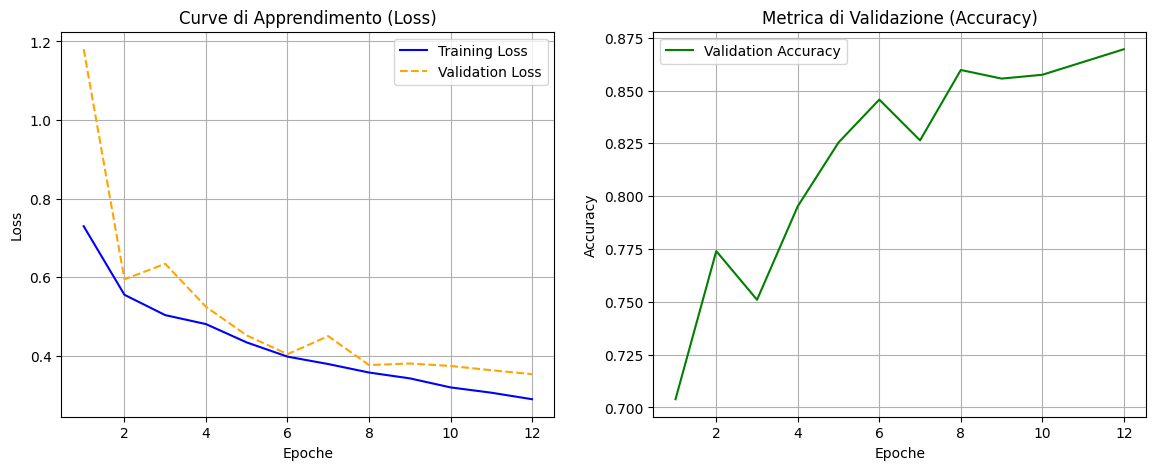

In [13]:
# ---------------------------------------------------------
# 3. TRAINING LOOP
# ---------------------------------------------------------

# Inizializziamo il modello e lo spostiamo sul device corretto
model = UNet(n_channels=3, n_classes=3).to(device)

# Loss Function e Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- FUNZIONE 1: Addestramento per singola epoca ---
def train_one_epoch(epoch_index, model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device).squeeze(1).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(dataloader)
    return avg_train_loss

# --- FUNZIONE 2: Validazione ---
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).squeeze(1).long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            # Calcolo accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_pixels += torch.eq(preds, masks).sum().item()
            total_pixels += torch.numel(preds)

    avg_val_loss = running_loss / len(dataloader)
    avg_val_acc = correct_pixels / total_pixels
    return avg_val_loss, avg_val_acc

# ---------------------------------------------------------
# CICLO PRINCIPALE E GRAFICI
# ---------------------------------------------------------
print("Inizio Addestramento Modulare per Analisi Convergenza...")
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # Eseguiamo un'epoca di train e una di validazione
    train_loss = train_one_epoch(epoch, model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)

    # Salviamo i dati
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# ---------------------------------------------------------
# STAMPA DEI GRAFICI FINALI
# ---------------------------------------------------------
print("Training completato. Generazione grafici...")
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Grafico 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='blue')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Curve di Apprendimento (Loss)')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Grafico 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', color='green')
plt.title('Metrica di Validazione (Accuracy)')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()